In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import sklearn 
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import pysubgroup as ps
import warnings
warnings.filterwarnings("ignore")

In [16]:
df_anime = pd.read_csv('anime_filtered.csv')
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14474 entries, 0 to 14473
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        14474 non-null  int64  
 1   title           14474 non-null  object 
 2   title_english   5723 non-null   object 
 3   title_japanese  14440 non-null  object 
 4   title_synonyms  8936 non-null   object 
 5   image_url       14378 non-null  object 
 6   type            14474 non-null  object 
 7   source          14474 non-null  object 
 8   episodes        14474 non-null  int64  
 9   status          14474 non-null  object 
 10  airing          14474 non-null  bool   
 11  aired_string    14474 non-null  object 
 12  aired           14474 non-null  object 
 13  duration        14474 non-null  object 
 14  rating          13932 non-null  object 
 15  score           14474 non-null  float64
 16  scored_by       14474 non-null  int64  
 17  rank            12901 non-null 

### Formulate a task for dividing into groups using clustering methods

In [17]:
df = df_anime[df_anime.score > 0] 

For clustering, let's try to identify groups of anime that are similar in their parameters and metrics that users have set for them. This will allow us to better understand how anime is evaluated depending on the characteristics, as well as better understand what the main "types" of anime exist, which can help creators when creating titles.

For the initial characteristics, let's take numerical parameters, as well as the source, genre, type (full-length /TV series /...).

### Which clustering algorithm did you use? Draw conclusions. How will they help in solving the main task?

I decided to use the k-means method and look at hierarchical clustering to identify the most likely subgroups.

In [18]:
df_cleaned = df[['score', 'type', 'source', 'rating', 'episodes', 'scored_by', 'members', 'favorites', 'genre']]

Converting genres to dummy variables:

In [19]:
df_cleaned['genres'] = df_cleaned.genre.str.split(pat=", ")
genres = df_cleaned['genres']
genres_dummy = pd.get_dummies(genres.explode()).groupby(level=0).sum()

Converting other variables:

In [20]:
df_3_dummies = pd.get_dummies(df_cleaned, columns = ['type', 'source', 'rating'], dtype='int64')

In [21]:
df_type = df_3_dummies.filter(like='type')
df_rating = df_3_dummies.filter(like='rating')
df_source = df_3_dummies.filter(like='source')

Let's combine everything into one dataframe:

In [22]:
df_metrics = df_cleaned[['score', 'episodes', 'scored_by', 'members', 'favorites']]

In [23]:
df_result = pd.concat([df_metrics, genres_dummy, df_type, df_rating, df_source], axis=1)
df_result.head(5)

,score,episodes,scored_by,members,favorites,Action,Adventure,Cars,Comedy,Dementia,...,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Unknown,source_Visual novel,source_Web manga
0,7.63,12,139250,283882,2809,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,7.89,26,91206,204003,2579,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,7.55,51,37129,70127,802,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,8.21,38,36501,93312,3344,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8.67,25,107767,182765,2082,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


Standartize the variables:

In [24]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_result)
scaled_df[:1]

array([[ 1.20368403,  0.00983668,  2.92425098,  3.43658215,  0.94048656,
        -0.5318212 , -0.4661238 , -0.08097186,  1.32186437, -0.14478551,
        -0.16310335, -0.43265465, -0.22420459, -0.4771165 , -0.14143668,
        -0.1579991 , -0.30623759, -0.26686568, -0.17050231, -0.07547439,
        -0.40473467, -0.26025969, -0.14781484, -0.27380222, -0.1853278 ,
        -0.32161701, -0.20768116, -0.19725964, -0.12374015, -0.14143668,
         2.80072895, -0.11037611, -0.32575509, -0.43034593, -0.2231576 ,
        -0.21607271, -0.06693637,  2.67483353, -0.07257344, -0.34277321,
        -0.17570902, -0.21227587, -0.19354957,  3.32743067, -0.08185309,
        -0.09256879, -0.05055063, -0.05395657, -0.46803577, -0.25289287,
        -0.29276252, -0.5820376 , -0.39795673,  1.55905529, -0.68591845,
        -0.31405571,  1.36604225, -0.27065158, -0.25714429, -0.30637587,
        -0.12403473, -0.08141364, -0.06195122, -0.02380615, -0.20544535,
        -0.19764672,  1.91548712, -0.15005007, -0.1

Look at the silhouette metric to find the optimal number of clusters:

In [25]:
sil = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(scaled_df)
    sil.append(metrics.silhouette_score(scaled_df, kmeans.labels_))

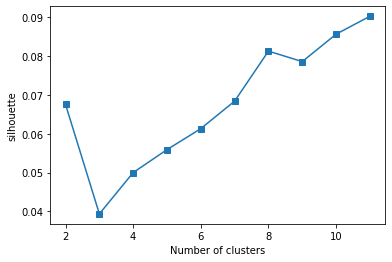

In [26]:
plt.plot(range(2, 12), sil, marker='s');
plt.xlabel('Number of clusters')
plt.ylabel('silhouette');

The graph shows that a sharp increase in silhouette falls from 3 to 4 clusters, as well as from 7 to 8. In any case, the metric itself is quite low, which suggests that it is quite difficult to identify any isolated subgroups of anime. Let's look at the descriptive statistics for 4 clusters:

In [29]:
kmodel_final = KMeans(n_clusters=4)
kmodel_final.fit(scaled_df)

KMeans(n_clusters=4)

In [30]:
res = df_result.copy()
res["cluster"] = kmodel_final.labels_
res.groupby("cluster").mean().T

cluster,0,1,2,3
score,6.172483,5.786451,6.937001,5.184089
episodes,2.064356,14.239659,12.357188,1.250000
scored_by,1453.287129,849.994786,25182.167883,663.359813
members,3563.870462,1908.030414,49763.371628,1230.526869
favorites,23.423267,5.919360,704.273881,5.039720
...,...,...,...,...
source_Picture book,0.000000,0.015989,0.000000,0.001168
source_Radio,0.000000,0.001390,0.000159,0.000000
source_Unknown,0.226073,0.476017,0.155506,0.238318
source_Visual novel,0.465347,0.002259,0.047128,0.003505


Several conclusions can be drawn from the table: there are 4 clusters, one of which contains full-length anime and 3 with multi-series anime with different average ratings (high/above average/low). 

In a cluster with highly rated multi-part anime, it is also noticeable that many people add such anime to their "favorites" tab. The 2 clusters differ mainly in their primary source - in the first case, they are original anime, in the second (and more successful) they derive from manga.

If we talk about the cluster of low-rated multi-part anime, there a lot of anime with no age restriction.

There were a lot of OVA-type anime in the cluster of small-scale series (small stories that complement the main plot of the anime). In addition, it consists of anime of the adult genre, and for the most part the primary source is visual novels.

Let's try to look at the dendrogram, maybe there will be a better view of the possible division into clusters:

In [127]:
from scipy.cluster.hierarchy import linkage, dendrogram
mergings = linkage(scaled_df, method='average')

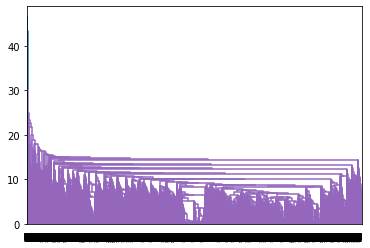

In [128]:
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=3,
           )

plt.show()

The result of the construction was not successful, which is not surprising - there is a lot of data, as well as potential cluster.

### Formulate a task for highlighting rules using Subgroup Discovery methods

I will use the subgroup discovery method to identify a set of genres that lead to a high score. Thus, it will be possible to guess which genre of anime will have better success among viewers.

In [186]:
target = ps.NumericTarget('score')

In [187]:
df_score = df_cleaned[['score']]
df_discovery = pd.concat([df_score, genres_dummy], axis=1)
df_discovery.head(5)

,score,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,7.63,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,7.89,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7.55,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.21,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8.67,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
searchspace = ps.create_selectors(df_discovery, ignore=['score'])

In [189]:
task = ps.SubgroupDiscoveryTask (
    df_discovery,
    target,
    searchspace,
    result_set_size=5,
    depth=3,
    qf=ps.StandardQFNumeric(a = 0.3)
)

In [190]:
result = ps.BeamSearch().execute(task)

In [191]:
result.to_dataframe()

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,6.886302,Mecha==0 AND Shounen==1 AND Space==0,1477,14124,7.067644,6.296435,0.828613,1.107903,7.15,6.4,9.25,10.0,3.63,1.0,1.122483,1.117188
1,6.882736,Comedy==1 AND Ecchi==0 AND Shounen==1,853,14124,7.205252,6.296435,0.748095,1.107903,7.28,6.4,9.25,10.0,4.42,1.0,1.144338,1.137500
2,6.868470,Horror==0 AND Mecha==0 AND Shounen==1,1466,14124,7.067374,6.296435,0.832868,1.107903,7.15,6.4,9.25,10.0,3.63,1.0,1.122440,1.117188
3,6.857823,Cars==0 AND Mecha==0 AND Shounen==1,1489,14124,7.062592,6.296435,0.836550,1.107903,7.16,6.4,9.25,10.0,3.63,1.0,1.121681,1.118750
4,6.854607,Comedy==1 AND Horror==0 AND Shounen==1,924,14124,7.180087,6.296435,0.753121,1.107903,7.26,6.4,9.25,10.0,3.69,1.0,1.140342,1.134375


What conclusion can be drawn from the results? The most obvious one is Shounen genre is the key to the success of the anime. This is not surprising - the genre is very popular and is aimed at a large target audience, so various combinations of other genres with it bring the anime success. Surprisingly, the Mecha genre (anime about huge controlled robots) is not as in demand as I expected - given that the genre itself is quite popular (although in the last few years the quality of such anime has clearly suffered). 
If we talk directly about combinations, then anime will most likely be highly appreciated if it doesn't have Mecha and Space / Horror / Cars genre. If you add Comedy to the Shounen and do not include Eroticism / Horror, then the anime will also be warmly received by the public.

If we summarize the entire classification, then to achieve success by the author of the anime:
* it is not necessary to target all age groups:

* do not include erotica

* make anime in the Shounen genre. 

No robots!